<a href="https://colab.research.google.com/github/vanithakattumuri/PAMI/blob/main/notebooks/uncertainFrequentPatterns/basic/PUFGrowth.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Finding Frequent Patterns in Uncertain Databases using PUFGrowth

This tutorial has two parts. In the first part, we describe the basic approach to find Frequent Patterns in a Uncertain database using the PUFGrowth algorithm. In the final part, we describe an advanced approach, where we evaluate the PUFGrowth algorithm on a dataset at different minimum support threshold values.
***

# Prerequisites:



1.   Installing the PAMI library

In [1]:
!pip install -U pami #install the pami repository

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 835.0/835.0 kB 10.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Created wheel for JsonForm: filename=JsonForm-0.0.2-py3-none-any.whl size=3313 sha256=18d74285e10b473ab0a8d6ce748292794537e1a80a6b2d782346fa9ff4776e86
  Stored in directory: /root/.cache/pip/wheels/b6/e5/87/11026246d3bd4ad67c0615682d2d6748bbd9a40ac0490882bd
  Created wheel for JsonSir: filename=JsonSir-0.0.2-py3-none-any.whl size=4750 sha256=7db163e0b5b46652ed13e36191dd6bf41200f75d84b5e8ce245ec85645f1fe6a
  Stored in directory: /root/.cache/pip/wheels/1d/4c/d3/4d9757425983b43eb709be1043d82cd03fb863ce5f56f117e6
Successfully built JsonForm JsonSir


2.   Downloading a sample dataset

In [3]:
!wget -nc https://u-aizu.ac.jp/~udayrage/datasets/uncertainDatabases/uncertainTransaction_T10I4D100K.csv #download a sample uncertain database

--2023-09-05 09:32:16--  https://u-aizu.ac.jp/~udayrage/datasets/uncertainDatabases/uncertainTransaction_T10I4D100K.csv
Resolving u-aizu.ac.jp (u-aizu.ac.jp)... 150.31.244.160, 150.95.161.176
Connecting to u-aizu.ac.jp (u-aizu.ac.jp)|150.31.244.160|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9972382 (9.5M) [text/csv]
Saving to: ‘uncertainTransaction_T10I4D100K.csv’

uncertainTransactio 100%[===================>]   9.51M  4.08MB/s    in 2.3s    

2023-09-05 09:32:19 (4.08 MB/s) - ‘uncertainTransaction_T10I4D100K.csv’ saved [9972382/9972382]



3.   Printing few lines of a dataset to know its format.

In [4]:
!head -2 uncertainTransaction_T10I4D100K.csv

25	52	164	240	274	328	368	448	538	561	630	687	730	775	825	834:0.688	0.758	0.612	0.44	0.249	0.862	0.523	0.472	0.334	0.093	0.808	0.73	0.04	0.385	0.229	0.151 
39	120	124	205	401	581	704	814	825	834:0.524	0.817	0.512	0.652	0.872	0.713	0.834	0.756	0.816	0.49 


format: every row contains items seperated by a seperator.

Example:

item1 item2 item3 item4

item1 item4 item6
***

## Part 1: Finding Frequent Patterns in Uncertain using PUFGrowth

### Step 1: Understanding the statistics of a database to choose an appropriate minimum support (minSup) value.

In [5]:
#import the class file
import PAMI.extras.dbStats.UncertainTransactionalDatabase as stats

#specify the file name
inputFile = 'uncertainTransaction_T10I4D100K.csv'

#initialize the class
obj=stats.UncertainTransactionalDatabase(inputFile,sep='\t')

#execute the class
obj.run()

#Printing each of the database statistics
print(f'Database size : {obj.getDatabaseSize()}')
print(f'Total number of items : {obj.getTotalNumberOfItems()}')
print(f'Database sparsity : {obj.getSparsity()}')
print(f'Minimum Transaction Size : {obj.getMinimumTransactionLength()}')
print(f'Average Transaction Size : {obj.getAverageTransactionLength()}')
print(f'Maximum Transaction Size : {obj.getMaximumTransactionLength()}')
print(f'Standard Deviation Transaction Size : {obj.getStandardDeviationTransactionLength()}')
print(f'Variance in Transaction Sizes : {obj.getVarianceTransactionLength()}')

#saving the distribution of items' frequencies and transactional lengths
itemFrequencies = obj.getSortedListOfItemFrequencies()
transactionLength = obj.getTransanctionalLengthDistribution()
obj.save(itemFrequencies, 'itemFrequency.csv')
obj.save(transactionLength, 'transactionSize.csv')

#Alternative apporach to print all of the database statistics and plot them
# obj.printStats()
# obj.plotGraphs()

Database size : 100000
Total number of items : 870
Database sparsity : 0.988388183908046
Minimum Transaction Size : 1
Average Transaction Size : 10.10228
Maximum Transaction Size : 29
Standard Deviation Transaction Size : 3.66716768114031
Variance in Transaction Sizes : 13.448253284132841


### Step 2: Draw the item's frequency graph and transaction length's distribution graphs for more information

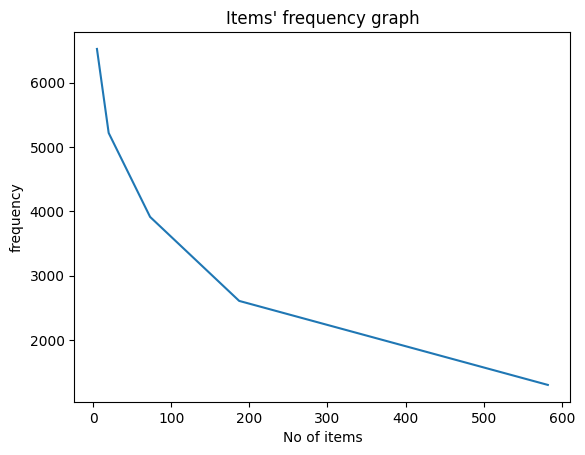

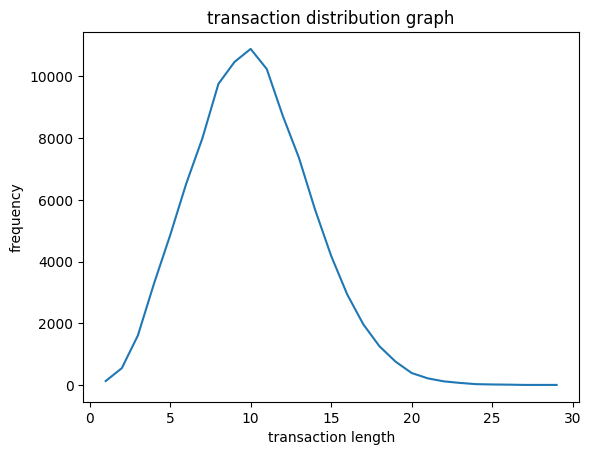

In [6]:
import PAMI.extras.graph.plotLineGraphFromDictionary as plt

itemFrequencies = obj.getFrequenciesInRange()
transactionLength = obj.getTransanctionalLengthDistribution()
plt.plotLineGraphFromDictionary(itemFrequencies, end = 100, title = 'Items\' frequency graph', xlabel = 'No of items', ylabel= 'frequency')
plt.plotLineGraphFromDictionary(transactionLength, end = 100, title = 'transaction distribution graph', xlabel = 'transaction length', ylabel = 'frequency')

### Step 3: Choosing an appropriate *minSup* value

_Observations_

  1. The input dataset is sparse as the sparsity value is 0.988 (=98.8%)
  2. Many items have low frequencies as seen in the items' frequency graph
  3. The dataset is not high dimensional as the inverted curve is around 10.

  Based on the above observations, let us choose a _minSup_ value of 100 (in count). We can increase or decrease the _minSup_ based on the number of patterns being generated.

In [7]:
minimumSupportCount = 300  #minSup is specified in count. However, the users can also specify minSup between 0 and 1.

### Step 4: Mining Frequent Patterns in Uncertain using PUFGrowth

In [8]:
from PAMI.uncertainFrequentPattern.basic import PUFGrowth as alg #import the algorithm

obj = alg.PUFGrowth(iFile=inputFile, minSup=minimumSupportCount, sep='\t') #initialize
obj.startMine()            #start the mining process

obj.save('uncertainFrequentPatternsAtMinSupCount300.txt') #save the patterns


frequentPatternsDF= obj.getPatternsAsDataFrame() #get the generated frequent patterns as a dataframe
print('Total No of patterns: ' + str(len(frequentPatternsDF))) #print the total number of patterns
print('Runtime: ' + str(obj.getRuntime())) #measure the runtime

print('Memory (RSS): ' + str(obj.getMemoryRSS()))
print('Memory (USS): ' + str(obj.getMemoryUSS()))

Uncertain Frequent patterns were generated successfully using PUFGrowth algorithm
Total No of patterns: 521
Runtime: 42.594239234924316
Memory (RSS): 720338944
Memory (USS): 673693696


### Step 5: Investigating the generated patterns

Open the pattern's file and investigate the generated patterns. If the generated patterns were interesting, use them; otherwise, redo the Steps 3 and 4 with a different _minSup_ value.

In [9]:
!head 'uncertainFrequentPatternsAtMinSupCount300.txt'

369:300.47 
0:301.5309999999999 
730:302.04799999999983 
408:302.0710000000001 
837:302.643 
249:307.3069999999998 
660:309.92600000000044 
833:313.02199999999993 
226:313.75700000000023 
167:314.3760000000002 


The storage format is: _uncertainFrequentPattern:support_
***

## Part 2: Evaluating the PUFGrowth algorithm on a dataset at different minSup values

### Step 1: Import the libraries and specify the input parameters

In [13]:
#Import the libraries
from PAMI.uncertainFrequentPattern.basic import PUFGrowth as alg #import the algorithm
import pandas as pd

#Specify the input parameters
inputFile = 'uncertainTransaction_T10I4D100K.csv'
seperator='\t'
minimumSupportCountList = [400, 500, 600, 700, 800]
#minimumSupport can also specified between 0 to 1. E.g., minSupList = [0.005, 0.006, 0.007, 0.008, 0.009]

### Step 2: Create a data frame to store the results of PUFGrowth

In [14]:
result = pd.DataFrame(columns=['algorithm', 'minSup', 'patterns', 'runtime', 'memory'])
#initialize a data frame to store the results of PUFGrowth algorithm

### Step 3: Execute the algorithm at different minSup values

In [15]:
for minSupCount in minimumSupportCountList:
    obj = alg.PUFGrowth(inputFile, minSup=minSupCount, sep=seperator)
    obj.startMine()
    #store the results in the data frame
    result.loc[result.shape[0]] = ['PUFGrowth', minSupCount, len(obj.getPatterns()), obj.getRuntime(), obj.getMemoryRSS()]

Uncertain Frequent patterns were generated successfully using PUFGrowth algorithm
Uncertain Frequent patterns were generated successfully using PUFGrowth algorithm
Uncertain Frequent patterns were generated successfully using PUFGrowth algorithm
Uncertain Frequent patterns were generated successfully using PUFGrowth algorithm
Uncertain Frequent patterns were generated successfully using PUFGrowth algorithm


### Step 4: Print the Result

In [16]:
print(result)

   algorithm  minSup  patterns      runtime      memory
0  PUFGrowth     400       441  1092.894774  1296531456
1  PUFGrowth     500       377  1080.548912  1273704448
2  PUFGrowth     600       322  1085.021140  1249775616
3  PUFGrowth     700       266  1074.044597  1220149248
4  PUFGrowth     800       214  1074.552245  1189400576


### Step 5: Visualizing the results

<Axes: xlabel='minSup'>

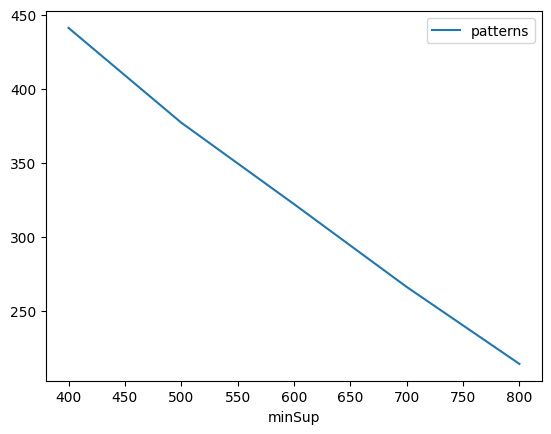

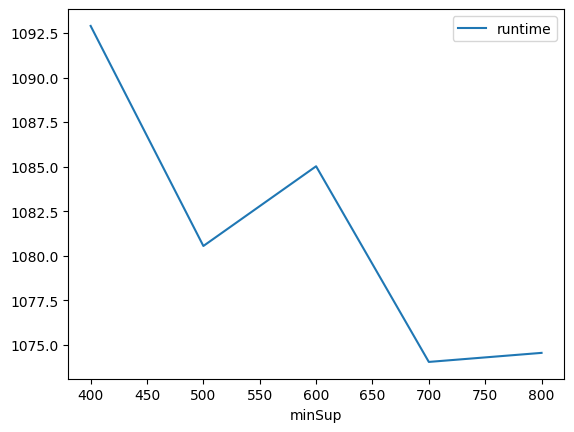

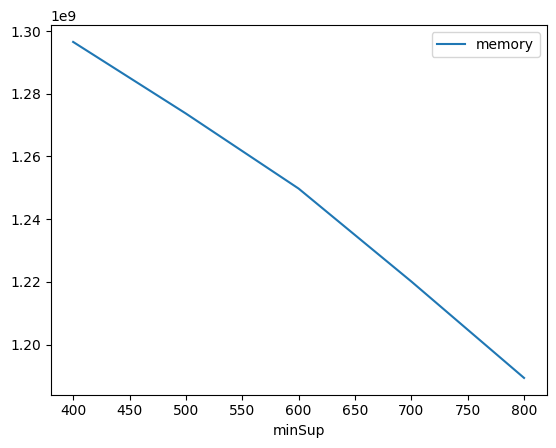

In [17]:
result.plot(x='minSup', y='patterns', kind='line')
result.plot(x='minSup', y='runtime', kind='line')
result.plot(x='minSup', y='memory', kind='line')

#Graphs can be improved further by using additional packages, such as plotly and matplotlib